<a href="https://colab.research.google.com/github/cathay/cnn/blob/master/eroad_driver_action_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import zipfile
import random
import tensorflow as tf
from shutil import copyfile
import pandas as pd
import numpy as np
import cv2
from sklearn.model_selection import train_test_split

#Import Google drive functions
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import shutil
#shutil.rmtree('tmp')

In [0]:
import shutil
DRIVE_PATH = '/content/drive/My Drive/colab/'
TRAIN_FILE = 'Thay_data_table.zip'

shutil.copyfile(DRIVE_PATH + TRAIN_FILE, TRAIN_FILE)

zip_ref = zipfile.ZipFile('Thay_data_table.zip', 'r')
zip_ref.extractall('tmp')
zip_ref.close()

In [40]:
from keras.utils import to_categorical
import imutils

TRAINING_DIR = 'tmp/Thay_data'
IMAGE_WIDTH=224
IMAGE_HEIGHT=224
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

def get_im_cv2(path, w, h):
  img = cv2.imread(path)
  return cv2.resize(img, (w,h), cv2.INTER_LINEAR) 

def get_center_roi(frame):
    # get the Region of Interest (y,y)
    height, width, channel = frame.shape
    midpoint_x = int(width / 2.0)
    midpoint_y = int(height / 2.0)
    left_x = midpoint_x - midpoint_y
    cropped = frame[0:height, left_x:width - left_x]
    return cropped

def to_resenet_input(path):
  img = cv2.imread(path)
  img = get_center_roi(img)
  return imutils.resize(img, width=IMAGE_WIDTH, height=IMAGE_HEIGHT)

files = []
categories = []
paths = []

actions = {
    'normal' : 0,
    'drinking': 1,
    'phone_left' : 2,
    'phone_right' : 3,
    'text_left': 4,
    'text_right': 5
}

NUM_CLASSESS = len(actions.keys())

#Should add class 0
for i in range(1,2):
  for dir_name in actions.keys():
    for file in os.listdir("%s_%s/%s" % (TRAINING_DIR, i, dir_name)):
      if file.endswith('png') or file.endswith('jpg') or file.endswith('jpeg'): #('.png', '.jpg', '.jpeg')
        files.append(file)
        categories.append(actions.get(dir_name))
        paths.append("%s_%s/%s/%s" %(TRAINING_DIR, i, dir_name, file))

df = pd.DataFrame({'file': files,
                   'category': categories,
                   'path': paths
                  })

df['Y'] = df['category'].map(lambda x: to_categorical(x, NUM_CLASSESS, dtype='uint8'))
df['X'] = df['path'].map(lambda path: to_resenet_input(path))
#df['X'] = df['path'].map(lambda path: get_im_cv2(path, IMAGE_WIDTH, IMAGE_HEIGHT))
#df.size
print("files:%s, paths size: %s, df[X]size: %s" % (len(files), len(paths), df['X'].size))
#df.sample(20, axis=None)

files:712, paths size: 712, df[X]size: 712


In [0]:
from keras.preprocessing.image import ImageDataGenerator
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

x_train = []
x_test = []
y_train = []
y_test= []

for item in train_df['X']:
  x_train.append(item)

for item in validate_df['X']:
  x_test.append(item)

for item in train_df['Y']:
  y_train.append(item)

for item in validate_df['Y']:
  y_test.append(item)

x_train = np.array(x_train, dtype=np.uint8)
x_test = np.array(x_test, dtype=np.uint8)
y_train = np.array(y_train, dtype=np.uint8)
y_test = np.array(y_test, dtype=np.uint8)

datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

datagen.fit(x_train)

In [42]:
#build model
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from tensorflow.python.keras import Sequential
from tensorflow.keras.optimizers import RMSprop, SGD
from tensorflow.keras.applications.resnet50 import ResNet50

import math

#from keras.models import Sequential
#from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
#from keras.optimizers import RMSprop, SGD
#from keras.applications.resnet50 import ResNet50
#from keras.applications.vgg16 import VGG16

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS))
#base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS))

model = Sequential()
model.add(base_model)

model.add(Flatten())
model.add(Dense(1024))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax')) # 

for layer in base_model.layers:
    layer.trainable = False

#model.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=0.0001), metrics=['accuracy'])
#model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

#model.summary()

## Train
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.applications.vgg16 import preprocess_input

earlystop = EarlyStopping(patience=5)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.0001)
EPOCHS=20
BATCH_SIZE=32
callbacks = [learning_rate_reduction]

# history = model.fit(x_train, 
#                     y_train,
#                     shuffle=True,
#                     batch_size=BATCH_SIZE,
#                     epochs=EPOCHS,
#                     verbose=1,
#                     validation_data=(x_test, y_test))
#                     #,callbacks=callbacks)

#Should use fit
history = model.fit_generator(
    datagen.flow(x_train, y_train, batch_size=BATCH_SIZE),
    epochs=EPOCHS,
    shuffle=True,
    validation_data=(x_test, y_test),
    steps_per_epoch=math.ceil(len(x_train)/BATCH_SIZE) # can be optimized
)
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/20
18/18 [==============================] - 8s 429ms/step - loss: 2.1496 - accuracy: 0.2109 - val_loss: 1.3577 - val_accuracy: 0.4266
Epoch 2/20
18/18 [==============================] - 7s 382ms/step - loss: 1.4092 - accuracy: 0.4833 - val_loss: 0.6344 - val_accuracy: 0.7483
Epoch 3/20
18/18 [==============================] - 7s 378ms/step - loss: 1.0829 - accuracy: 0.6011 - val_loss: 0.4100 - val_accuracy: 0.8741
Epoch 4/20
18/18 [==============================] - 7s 372ms/step - loss: 0.7903 - accuracy: 0.7118 - val_loss: 0.3562 - val_accuracy: 0.9091
Epoch 5/20
18/18 [==============================] - 7s 377ms/step - loss: 0.6500 - accuracy: 0.7750 - val_loss: 0.3101 - val_accuracy: 0.9231
Epoch 6/20
18/18 [==============================] - 7s 374ms/step - loss: 0.5546 - accuracy: 0.8278 - val_loss: 0.2988 - val_accuracy: 0.9091
Epoch 7/20
18/18 [==============================] - 7s 373ms/step - loss: 0.5227 - accuracy: 0.8401 - val_loss: 0.2726 - val_accuracy: 0.9231
Epoch 

In [43]:
MODEL_FILE_NAME = 'eroad_action_detection_resnet_10_epoch_augmentation_v3.h5'
model.save(MODEL_FILE_NAME)
shutil.copyfile(MODEL_FILE_NAME, DRIVE_PATH + 'model/'+ MODEL_FILE_NAME)

'/content/drive/My Drive/colab/model/eroad_action_detection_resnet_10_epoch_augmentation_v3.h5'

In [0]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg
[0.00413738 0.00210062 0.49949488 0.36918762 0.09413986 0.03093966]
2
Classified: phone_left


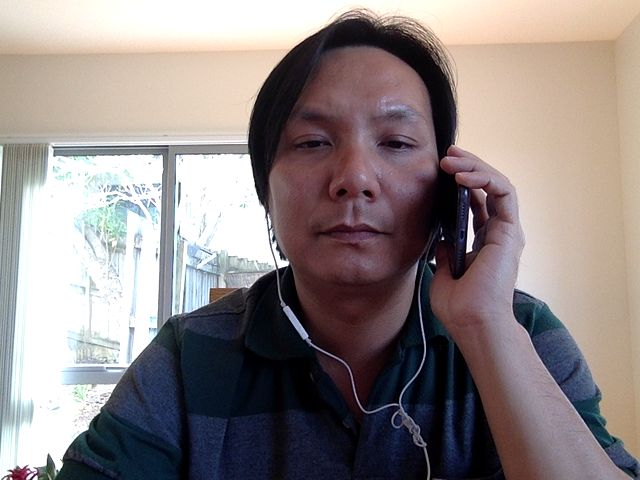

In [32]:


label_map = {
    0: 'normal',
    1: 'drinking',
    2: 'phone_left',
    3: 'phone_right',
    4: 'text_left',
    5: 'text_right'
}

from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  #img = get_im_cv2(filename, IMAGE_WIDTH, IMAGE_HEIGHT)
  img = get_center_roi(cv2.imread(filename))
  img = imutils.resize(img, width=224)
  x_predict=[]
  x_predict.append(img)
  x_predict = np.array(x_predict, dtype=np.uint8)
  prediction = model.predict(x_predict);

  label = np.argmax(prediction)

  print(*prediction) 
  print(label)
  print("Classified: %s" % (label_map.get(label)))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))